**Vision**

The best way to prevent crime is to know the patterns of crime. A good way to avoid becoming a victim of a crime is to avoid places where crime can occur. If people know the possibility of a crime in each place or know the possibility of being exposed to a crime on a certain day, they can be prevented from harm. Today, programs that predict crime for patrol purposes, such as Predpol, are being used. However, there are a few ways that ordinary people or pedestrians can predict crime and reduce damage. The purpose of this project is to make LSTM-based neural networks for predicting crimes for general public use.

**Background**

I used LSTM (long short term memory network) to build the model. I assume that crime relates to the sequence of time. For example, crimes that occur today are likely to be related to past crimes and affect future crimes.  Therefore, LSTM, recurrent neural network, suitable for learning since it is specialized for sequence data. I reference two papers Forecasting Crime with Deep Learning by Alexander Stec and Diego Klabjan and Predictive Analysis of Crime Data Using Deep Learning by Anish Krishnan, Aditya Sarguru, and A. C. Shantha Sheela. Both papers also noted that the relationship of the crime the sequence of time and use of LSTM for sequential data. In the use of the LSTM model, two papers don't specifically mention about which values are used as input values and what the image of the model. Therefore, I formed a model with limited information provided in the two papers. I also refer to the LSTM model mentioned in the class in forming the model.

**Implementation**

1. Data




 The data used in the learning is the GRPD Historic Crime Locations provided by GRData. This dataset contains information such as the latitude, longitude, date, time, offense title, offense code, etc. of the place where the crime occurred. Prior to creating the learning model, when I verified the usefulness of data, it was necessary to quantify the data on the crime and to clean the data. While the data cleansing, I deleted the meaningless string in dataset's date and time to make it consistent. The offense title of each data was inconsistent, and many offenses were not considered threats. For instance, if the offense is limited to domestic, fraud, gambling, etc., it is not a danger to pedestrians; therefore, I excluded offense that does not directly threaten pedestrian or visitor. As mentioned earlier, it was difficult to quantify because the offense title was inconsistent and impossible to use since it was not a numerical value. Moreover, I thought that it would be unreasonable to classify each offense as the same risk. In order to solve this problem, I used the offense codes to specify the weight of crime from 1 to 8 according to the information on the crime class level in Michigan. For instance, a serious crime such as murder is classified as class A and the class H with low importance, so I define class A and class H as weight 8 and 1.
In the paper, Alexander additionally used weather, public transportation, and census data for model learning. I used data from the National Centers for Environmental Information to add weather information for Grand Rapids. I excluded the data provided before 2013, from 2012 to 2003, due to the omission of data. Grand Rapids public transportation and census data were not provided, so I did not add for model learning.


2. Model

Because of continuous learning failure, I made three different models. I made the first LSTM model with reference to the model Krishnan mentioned in the paper. Krishnan did not set up windows for LSTM and did not explain input variables, so I decided to repeat 50 learning and predicting one value in forming the window in the LSTM model. As the paper mentioned, I setup loss as the mean squared error and the optimizer adam. The crime level was used as the target value and the other values, longitude, latitude, precipitation, average temperature, average wind speed, daily percent of possible sunshine for the period and crime level, as the input values.

For the second model, I used a simpler model because I assumed that previous failures might be due to the complexity of the model. This time, I made a regression model by referring to the Boston housing price model provided by keras tutorial. Since the amount of data set is sufficient, I excluded the K-fold validation in Boston housing example.

Finally, I recreated the LSTM model, but unlike the first model, I considered only the target and time order, excluding all inputs. I would describe the reason to set up the final model in this way which different to my purpose in the Results section.

**Results**

The results of the first model demonstrate that the model did not perform well. When comparing the predicted values of the test data with the true values, predict shows a straight line with some ignorable curve but no relation to the true value.
The second model does not show a straight line on the graph, unlike the first model, but it is difficult to find a connection when comparing the prediction with the true value.
The third model also shows that the result is not positive, but unlike the two relatively advanced models, the predicted value follows a very small pattern of true values. However, this is also about 20 degrees of accuracy, so it is difficult to argue reliability.


Hence, I suspect three reasons for those results. The first is that the connection of the data is not sufficiently related to finding the pattern by learning. I have found several crime predictions and neural network papers, and in most of the papers, they made a model using a convolutional neural network. In most of the theses, they used it with image data as well as numerical data. For example, some papers have created a crime prediction model based on street views and criminal records, and in many cases, a crime map dataset based on crime data was created to predict the image pattern through CNN. Therefore, using only numeric data would be limited.
The second reason is that I have not bucketed the data by date. Alexander explains that when they did modeling, they bucketed by date and then created a model that predicted the next day based on the results. This means, in other words, that while using LSTM, the size of windows should be equal to the data size of the bucketing date. However, the data size of each date was not constant. Therefore, implementing bucketing was not realistic.
Finally, there may have been a problem that there was a lot of overlapping coordinate data. These latitude-longitude data, if possible, may be addressed by bucketing by zone. For Chicago data, it divides the area into community areas, but Grand Rapids data is not able to do that. Furthermore, overlapping coordinates have different class levels which may make difficult to associate patterns.


**Implications**

It seems that the algorithm itself has relatively low possibility to create an ethical problem compare to how to construct a dataset. When looking at the papers, it was often overlooked how they distinguished crime types from crime data. In many cases, they were only interested in crime patterns. It seems to be more ethical issues arising from how to collect and evaluate data. LSTM only perceives temporal patterns based on the given sequence data. If the data are discriminative and bias, the results will be equally discriminative.

**Models**

1. First LSTM Model

In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout

In [0]:
# read csv file and drop NaN values
gr_crime_dataframe =  pd.read_csv("https://raw.githubusercontent.com/ChanKim04/cs344/master/Project/dataset/dataset.csv", header=0)
gr_crime_dataframe = gr_crime_dataframe.dropna()

In [43]:
# X = Longitude; Y = Latitude; PRCP = Precipitation;
# TAVG = Average temperature; AWND = Average wind speed;
# PSUN = Daily percent of possible sunshine for the period;
# class = level of crime class
gr_crime_dataframe = gr_crime_dataframe[['X', 'Y', 'PRCP', 'TAVG', 'AWND', 'PSUN', 'class']]
gr_crime_dataframe.head()

,X,Y,PRCP,TAVG,AWND,PSUN,class
0,-85.649630,42.981756,0.0,33,12.3,52,4.0
1,-85.655073,42.938241,0.0,33,12.3,52,4.0
2,-85.678995,42.969006,0.0,33,12.3,52,4.0
3,-85.662106,42.999072,0.0,33,12.3,52,8.0
4,-85.644578,42.962804,0.0,33,12.3,52,8.0


In [0]:
dataset = gr_crime_dataframe[-2000:]

In [0]:
train_size = int(len(dataset) * 0.90)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

In [0]:
def create_dataset(dataset, look_back):
  dataX, dataY = [], []
  
  for i in range(len(dataset)-look_back-1):
    a = dataset[['X', 'Y', 'PRCP', 'TAVG', 'AWND', 'PSUN']][i:i+look_back]

    b = dataset[['class']][i:i+look_back]
    b = np.array(b).tolist()[0][0]
    dataX.append(np.array(a))
    dataY.append(b)
    
  return np.array(dataX), np.array(dataY)

In [0]:
look_back = 50
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [38]:
print('trainX shape:', trainX.shape)
print('trainY shape:', trainY.shape)
print('testX shape:', testX.shape)
print('testY shape:', testY.shape)

trainX shape: (1749, 50, 6)
trainY shape: (1749,)
testX shape: (149, 50, 6)
testY shape: (149,)


In [39]:
model = Sequential()
model.reset_states()

model.add(LSTM(50, return_sequences=True, input_shape=(50,6)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer='adam', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50, 50)            11400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 71,901
Trainable params: 71,901
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit(trainX, trainY,
                    validation_data=(testX, testY),
                    batch_size=20,
                    nb_epoch=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 1749 samples, validate on 149 samples
Epoch 1/100
1749/1749 [==============================] - 14s 8ms/step - loss: 4.7956 - acc: 0.1349 - val_loss: 5.1679 - val_acc: 0.0268
Epoch 2/100
1749/1749 [==============================] - 13s 7ms/step - loss: 4.1827 - acc: 0.1326 - val_loss: 5.2438 - val_acc: 0.0268
Epoch 3/100
1749/1749 [==============================] - 13s 7ms/step - loss: 4.1915 - acc: 0.1121 - val_loss: 5.1453 - val_acc: 0.0403
Epoch 4/100
1749/1749 [==============================] - 13s 7ms/step - loss: 4.2139 - acc: 0.1132 - val_loss: 5.1638 - val_acc: 0.0268
Epoch 5/100
1749/1749 [==============================] - 14s 8ms/step - loss: 4.1333 - acc: 0.1298 - val_loss: 5.1972 - val_acc: 0.0268
Epoch 6/100
1749/1749 [==============================] - 13s 7ms/step - loss: 4.1589 - acc: 0.1098 - val_loss: 5.1330 - val_acc: 0.0268
Epoch 7/100
1749/1749 [==============================] - 14s 8ms/step - loss: 4.1515 - acc: 0.1286 - val_loss: 5.2223 - val_acc: 0.0268
E

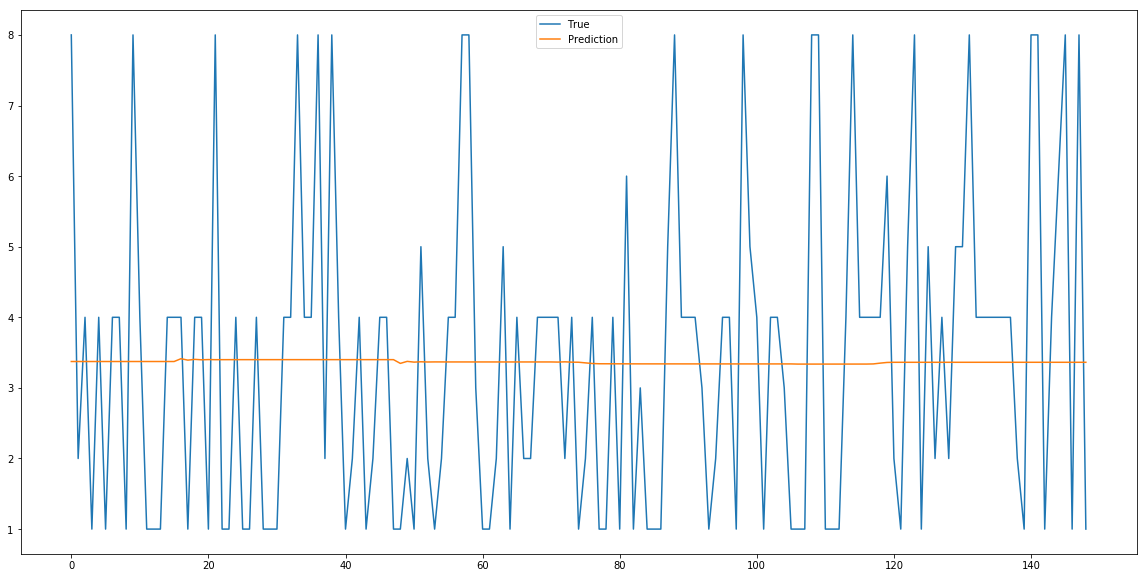

In [16]:
pred = model.predict(testX)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(testY, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

2. Regression model

In [0]:
dataset2 = gr_crime_dataframe[-2000:]

In [0]:
dataset2 = dataset2.values

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
# values = gr_crime_dataframe.values
# integer encode direction
encoder = LabelEncoder()
dataset2[:,4] = encoder.fit_transform(dataset2[:,4])
# ensure all data is float
dataset2 = dataset2.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
dataset2 = scaler.fit_transform(dataset2)

In [0]:
train_size = int(len(dataset2) * 0.90)
test_size = len(dataset2) - train_size
train, test = dataset2[0:train_size], dataset2[train_size:len(dataset2)]

In [28]:
trainX = train[:, :-1]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
trainY = train[:, -1]

testX = test[:, :-1]
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))
testY = test[:, -1]

trainX.shape, testX.shape

((1800, 6), (200, 6))

In [29]:
model = Sequential()
model.reset_states()
model.add(Dense(64, activation='relu',
                input_shape=(trainX.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(trainX, trainY,
                    validation_data=(testX, testY),
                    epochs=100, batch_size=10, verbose=0)
mae_history = history.history['val_mean_absolute_error']

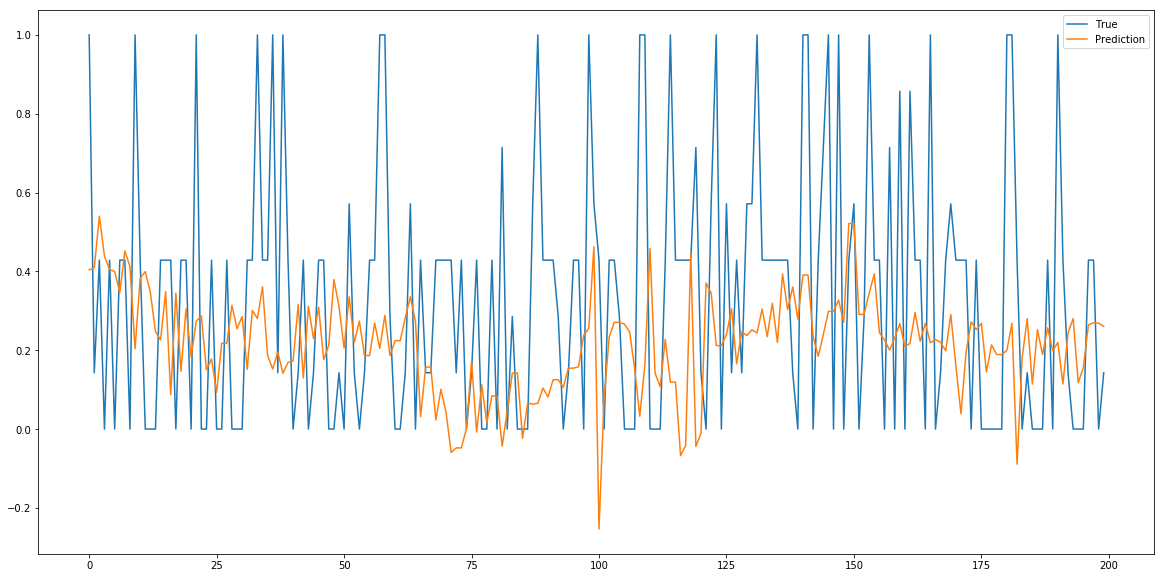

In [31]:
pred = model.predict(testX)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(testY, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

3. Second LSTM model

In [0]:
dataset3 = gr_crime_dataframe[-2000:]

In [0]:
data = dataset3[['PRCP', 'TAVG', 'AWND', 'PSUN']]
target_value = dataset3[['class']]
target_value = target_value['class'].values

In [0]:
seq_len = 50
sequence_length = seq_len + 1
result = []
for index in range(len(target_value) - sequence_length):
    result.append(target_value[index: index + sequence_length])

In [0]:
# normalize data accoridng to the first row of value
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window] 
    normalized_data.append(normalized_window)

result = np.array(normalized_data)
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]

In [0]:
trainX = train[:, :-1]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
trainY = train[:, -1]

testX = result[row:, :-1]
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
testY = result[row:, -1]

In [51]:
model = Sequential()
model.reset_states()
model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(1, activation='linear')) # change relu to linear
model.compile(loss='mse', optimizer='rmsprop', metrics=['acc']) # change optimizer: adam -> rmsprop
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model.fit(trainX, trainY,
                    validation_data=(testX, testY),
                    batch_size=20,
                    nb_epoch=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 1754 samples, validate on 195 samples
Epoch 1/100
1754/1754 [==============================] - 15s 8ms/step - loss: 1.6878 - acc: 0.2138 - val_loss: 1.7565 - val_acc: 0.1128
Epoch 2/100
1754/1754 [==============================] - 13s 7ms/step - loss: 1.6451 - acc: 0.2115 - val_loss: 1.8258 - val_acc: 0.1231
Epoch 3/100
1754/1754 [==============================] - 13s 7ms/step - loss: 1.6026 - acc: 0.2041 - val_loss: 1.7710 - val_acc: 0.2359
Epoch 4/100
1754/1754 [==============================] - 14s 8ms/step - loss: 1.6138 - acc: 0.2115 - val_loss: 1.7551 - val_acc: 0.1128
Epoch 5/100
1754/1754 [==============================] - 13s 7ms/step - loss: 1.6066 - acc: 0.2144 - val_loss: 1.7667 - val_acc: 0.1333
Epoch 6/100
1754/1754 [==============================] - 13s 7ms/step - loss: 1.5844 - acc: 0.2115 - val_loss: 1.9148 - val_acc: 0.1333
Epoch 7/100
1754/1754 [==============================] - 13s 7ms/step - loss: 1.6088 - acc: 0.2155 - val_loss: 1.7545 - val_acc: 0.1179
E

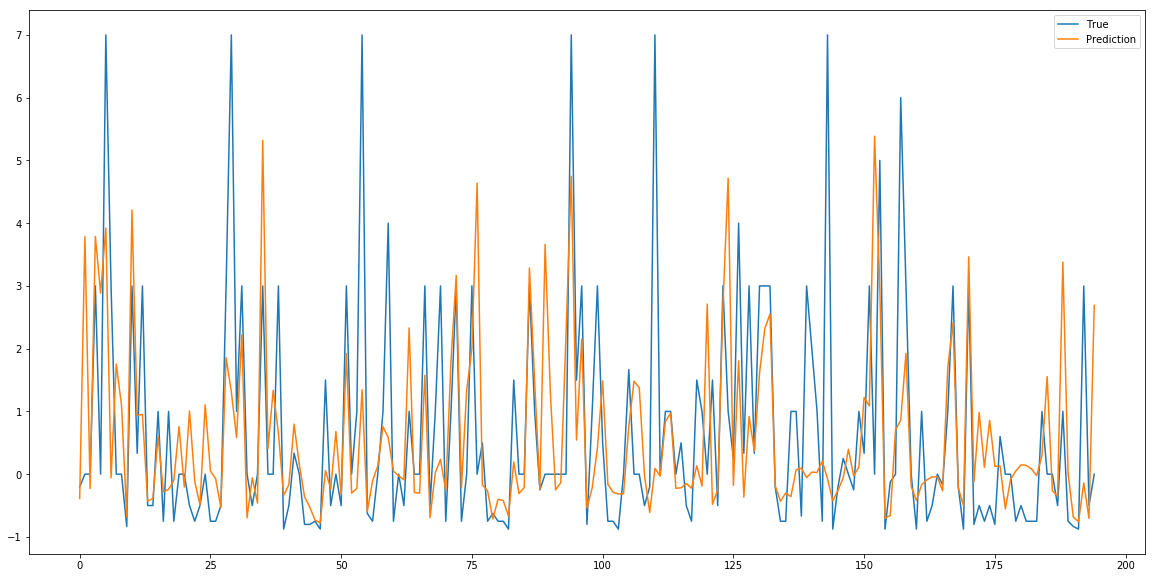

In [53]:
pred = model.predict(testX)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(testY, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

**Bibliography**



1.  Baldwin, Lauren. “Michigan Felony Crimes by Class and Sentences.” Criminal Defense Lawyer. https://www.criminaldefenselawyer.com/resources/criminal-defense/state-felony-laws/michigan-felony-class.htm
2. Krishnan, Anish, Sarguru, Aditya and Sheela, A. C. Shantha. “Predictive Analysis of Crime Data Using Deep Learning. International Journal of Pure and Applied Mathematics.” 2018, Vol. 118(20) 4023-4031
3. Michigan Incident Crime Reporting, “MICR ARREST CHARGE CODES.” https://www.michigan.gov/documents/MICRArrestCodes_June06_163082_7.pdf
4. Stec, Alexander, and Diego Klabjan. "Forecasting Crime with Deep Learning." arXiv preprint arXiv. 2018 1806.01486.
